# Project 1a: State-Level Census Analysis & Choropleth Mapping

**Geospatial Data Analysis Tutorial - Phase 1 (Foundation)**

Welcome to Project 1a! Building on the mapping fundamentals from Project 0, we'll now dive into **demographic data analysis** and **choropleth mapping** using real US Census data at the **state level**.

## 🎯 Learning Objectives

By the end of this notebook, you will:
- Master US Census API basics with state-level data
- Create professional choropleth maps showing demographic patterns
- Perform statistical analysis of population demographics
- Understand data classification methods for mapping
- Build visualizations with multiple data layers
- Apply basic geospatial joins and data integration techniques

## 📊 What We'll Analyze

1. **Census API Setup** - Access live Census data programmatically
2. **State-Level Analysis** - Population, income, and demographic patterns across all 50 states
3. **Statistical Analysis** - Correlation, distribution analysis, and pattern identification
4. **Professional Choropleth Design** - Classification schemes and color theory
5. **Multi-variable Visualization** - Comparing multiple demographic indicators

## 🗺️ Key Datasets

- **US Census Bureau**: American Community Survey (ACS) 5-year estimates (state-level)
- **Census TIGER/Line**: State administrative boundaries
- **Demographics**: Population, income, education, housing, work patterns

## 🎓 Skill Level: **Foundation**
- **Prerequisites**: Completion of Project 0 (Cartography basics)
- **Target Audience**: Beginners to Census data and demographic mapping
- **Time Required**: 1-2 hours
- **Next Steps**: Project 1b (County-level deep dive with ML techniques)

Let's begin exploring the demographic landscape of America at the state level! 🇺🇸

## 1. Environment Setup & Library Imports

First, let's import all the required libraries for Census data analysis and choropleth mapping. We'll use the Census API for live data access.

In [1]:
# Core geospatial and data analysis libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec

# Census data access
import requests
import json
from urllib.parse import urlencode

# Utility libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up high-quality plotting
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("✅ All libraries imported successfully!")
print(f"GeoPandas version: {gpd.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Python version: {sys.version.split()[0]}")

# Setup project paths
project_root = Path('..')
data_dir = project_root / 'data'
raw_data_dir = data_dir / 'raw'
processed_data_dir = data_dir / 'processed'
outputs_dir = project_root / 'outputs'
figures_dir = outputs_dir / 'figures'

# Create directories if they don't exist
for directory in [raw_data_dir, processed_data_dir, figures_dir]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"📁 Project directories ready!")
print(f"   Data: {data_dir}")
print(f"   Outputs: {figures_dir}")

✅ All libraries imported successfully!
GeoPandas version: 1.1.1
Pandas version: 2.2.2
Matplotlib version: 3.8.4
Python version: 3.11.13
📁 Project directories ready!
   Data: ../data
   Outputs: ../outputs/figures


## 2. US Census API Setup & Data Access

The US Census Bureau provides free access to demographic data through their API. We'll access the **American Community Survey (ACS) 5-year estimates**, which provides reliable demographic data at state and county levels.

**Key Census Datasets:**
- **ACS 5-Year**: Most detailed demographic data (population, income, education, housing)
- **TIGER/Line**: Boundary files for states, counties, census tracts
- **Decennial Census**: Population counts every 10 years

We'll start by setting up our data access functions and getting state-level population data.

In [2]:
# Census API Configuration
CENSUS_BASE_URL = "https://api.census.gov/data"
CENSUS_YEAR = "2022"  # Using 2022 ACS 5-year estimates (latest available)

def fetch_census_data(variables, geography, state="*", county="*", year=CENSUS_YEAR):
    """
    Fetch data from US Census API
    
    Parameters:
    - variables: dict of {variable_code: descriptive_name}
    - geography: geographic level ('state', 'county')
    - state: state code ('*' for all states, '06' for CA, etc.)
    - county: county code ('*' for all counties)
    """
    
    # Build the API URL
    dataset = f"{CENSUS_BASE_URL}/{year}/acs/acs5"
    
    # Prepare variables string
    get_vars = ",".join(variables.keys())
    
    # Build geography parameter
    if geography == 'state':
        for_geo = "state:*"
    elif geography == 'county':
        if state == "*":
            for_geo = "county:*"
        else:
            for_geo = f"county:*&in=state:{state}"
    
    # Make the API request
    params = {
        'get': get_vars,
        'for': for_geo
    }
    
    try:
        response = requests.get(dataset, params=params)
        response.raise_for_status()
        
        data = response.json()
        
        # Convert to DataFrame
        df = pd.DataFrame(data[1:], columns=data[0])  # First row is headers
        
        # Rename columns to descriptive names
        rename_dict = {code: name for code, name in variables.items()}
        df = df.rename(columns=rename_dict)
        
        # Convert numeric columns
        for col in rename_dict.values():
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        print(f"✅ Fetched {len(df)} {geography} records")
        return df
        
    except Exception as e:
        print(f"❌ Error fetching Census data: {e}")
        return None

# Define key demographic variables we'll analyze
state_variables = {
    'B01003_001E': 'total_population',      # Total population
    'B19013_001E': 'median_household_income', # Median household income
    'B25001_001E': 'total_housing_units',   # Total housing units
    'B08303_001E': 'total_commuters',       # Total commuters
    'B15003_022E': 'bachelors_degree',      # Bachelor's degree or higher
    'B08006_008E': 'work_from_home',        # Work from home
}

print("📊 Fetching state-level demographic data...")
state_data = fetch_census_data(state_variables, 'state')

if state_data is not None:
    print(f"\n📈 State Data Preview:")
    print(f"   Shape: {state_data.shape}")
    print(f"   Columns: {', '.join(state_data.columns)}")
    
    # Display top 5 most populous states
    top_states = state_data.nlargest(5, 'total_population')[['state', 'total_population', 'median_household_income']]
    print(f"\n🏆 Top 5 Most Populous States:")
    for _, row in top_states.iterrows():
        print(f"   State {row['state']}: {row['total_population']:,} people, ${row['median_household_income']:,} median income")
else:
    print("❌ Failed to fetch state data")

📊 Fetching state-level demographic data...
✅ Fetched 52 state records

📈 State Data Preview:
   Shape: (52, 7)
   Columns: total_population, median_household_income, total_housing_units, total_commuters, bachelors_degree, work_from_home, state

🏆 Top 5 Most Populous States:
   State 06: 39,356,104 people, $91,905 median income
   State 48: 29,243,342 people, $73,035 median income
   State 12: 21,634,529 people, $67,917 median income
   State 36: 19,994,379 people, $81,386 median income
   State 42: 12,989,208 people, $73,170 median income


## 3. Load Geographic Boundaries & Create GeoDataFrame

Now we'll load the state boundaries from Census TIGER/Line files and merge them with our demographic data to create our first choropleth maps.

In [19]:
# Load US States boundaries - Simplified approach
print("📦 Loading US States boundaries...")

# Simplified Geographic Data Loading
print("📦 Loading US States boundaries...")

def load_states_data():
    """Load state boundaries with fallback options to ensure mapping works"""
    # Try multiple reliable sources for geographic boundaries
    sources = [
        ("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json", "PublicaMundi States"),
        ("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json", "Census Alternative"),
        ("https://raw.githubusercontent.com/datasets/geo-boundaries-us-110m/master/json/us_states_20m.json", "Datasets GeoJSON")
    ]
    
    for url, description in sources:
        try:
            print(f"   Trying {description}...")
            states_gdf = gpd.read_file(url)
            print(f"✅ Successfully loaded {len(states_gdf)} state boundaries from {description}")
            
            # Standardize column names based on the source
            if 'name' in states_gdf.columns and 'NAME' not in states_gdf.columns:
                states_gdf = states_gdf.rename(columns={'name': 'NAME'})
            elif 'properties' in str(states_gdf.columns):
                # Handle nested properties if needed
                pass
            
            # Create STATEFP if missing
            if 'STATEFP' not in states_gdf.columns:
                # Create state FIPS mapping
                state_fips_map = {
                    'Alabama': '01', 'Alaska': '02', 'Arizona': '04', 'Arkansas': '05', 'California': '06',
                    'Colorado': '08', 'Connecticut': '09', 'Delaware': '10', 'District of Columbia': '11',
                    'Florida': '12', 'Georgia': '13', 'Hawaii': '15', 'Idaho': '16', 'Illinois': '17',
                    'Indiana': '18', 'Iowa': '19', 'Kansas': '20', 'Kentucky': '21', 'Louisiana': '22',
                    'Maine': '23', 'Maryland': '24', 'Massachusetts': '25', 'Michigan': '26', 'Minnesota': '27',
                    'Mississippi': '28', 'Missouri': '29', 'Montana': '30', 'Nebraska': '31', 'Nevada': '32',
                    'New Hampshire': '33', 'New Jersey': '34', 'New Mexico': '35', 'New York': '36',
                    'North Carolina': '37', 'North Dakota': '38', 'Ohio': '39', 'Oklahoma': '40',
                    'Oregon': '41', 'Pennsylvania': '42', 'Rhode Island': '44', 'South Carolina': '45',
                    'South Dakota': '46', 'Tennessee': '47', 'Texas': '48', 'Utah': '49', 'Vermont': '50',
                    'Virginia': '51', 'Washington': '53', 'West Virginia': '54', 'Wisconsin': '55', 'Wyoming': '56'
                }
                
                if 'NAME' in states_gdf.columns:
                    states_gdf['STATEFP'] = states_gdf['NAME'].map(state_fips_map)
                    print(f"   ✅ Created STATEFP codes for merging")
                    
                    # Remove any rows without valid FIPS codes
                    states_gdf = states_gdf.dropna(subset=['STATEFP'])
                    print(f"   Cleaned to {len(states_gdf)} valid states")
            
            return states_gdf
            
        except Exception as e:
            print(f"❌ Failed to load {description}: {str(e)[:80]}...")
            continue
    
    # If all external sources fail, create a simple backup for analysis
    print("⚠️ All external sources failed - creating analysis-only version")
    
    # Create minimal DataFrame for analysis (without geometry)
    import pandas as pd
    state_fips = {
        '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
        '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia',
        '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois',
        '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana',
        '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota',
        '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada',
        '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York',
        '37': 'North Carolina', '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma',
        '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island', '45': 'South Carolina',
        '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah', '50': 'Vermont',
        '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming'
    }
    
    states_df = pd.DataFrame(list(state_fips.items()), columns=['STATEFP', 'NAME'])
    print(f"✅ Created backup state reference for {len(states_df)} states (no maps, but statistical analysis available)")
    
    return states_df

states_gdf = load_states_data()

states_gdf = load_states_data()

# Merge Census data with geographic boundaries
if states_gdf is not None and state_data is not None:
    print(f"\n🔄 Merging Census data with geographic boundaries...")
    
    # Prepare Census data for merging
    state_data_clean = state_data.copy()
    state_data_clean['STATEFP'] = state_data_clean['state'].astype(str).str.zfill(2)
    
    # Merge demographics with boundaries
    states_with_data = states_gdf.merge(state_data_clean, on='STATEFP', how='inner')
    
    if len(states_with_data) > 0:
        print(f"✅ Successfully merged data for {len(states_with_data)} states")
        print(f"   Final dataset: {states_with_data.shape}")
        
        # Check if we have geometry for mapping
        has_geometry = hasattr(states_with_data, 'geometry') and 'geometry' in states_with_data.columns
        print(f"   Geographic mapping: {'✅ Available' if has_geometry else '❌ Not available'}")
        
        # Preview merged data
        preview_cols = ['NAME', 'total_population', 'median_household_income']
        available_cols = [col for col in preview_cols if col in states_with_data.columns]
        if available_cols:
            print(f"\n📊 Sample merged data:")
            print(states_with_data[available_cols].head())
    else:
        print("❌ Merge failed - no matching records")
        states_with_data = None
        
elif state_data is not None:
    print("⚠️ Geographic data unavailable - will create statistical analysis only")
    states_with_data = None
else:
    print("❌ Cannot merge: Missing Census data")
    states_with_data = None

📦 Loading US States boundaries...
📦 Loading US States boundaries...
   Trying PublicaMundi States...
✅ Successfully loaded 52 state boundaries from PublicaMundi States
   ✅ Created STATEFP codes for merging
   Cleaned to 51 valid states
   Trying PublicaMundi States...
✅ Successfully loaded 52 state boundaries from PublicaMundi States
   ✅ Created STATEFP codes for merging
   Cleaned to 51 valid states

🔄 Merging Census data with geographic boundaries...
✅ Successfully merged data for 51 states
   Final dataset: (51, 12)
   Geographic mapping: ✅ Available

📊 Sample merged data:
         NAME  total_population  median_household_income
0     Alabama           5028092                    59609
1      Alaska            734821                    86370
2     Arizona           7172282                    72581
3    Arkansas           3018669                    56335
4  California          39356104                    91905
✅ Successfully loaded 52 state boundaries from PublicaMundi States
   ✅ C

## 4. Create Professional Choropleth Maps

Choropleth maps use colors to show how statistical values vary across geographic areas. Let's create professional choropleth maps showing demographic patterns across US states.

**Key Design Principles:**
- **Color schemes**: Sequential (low→high), diverging (negative↔positive), qualitative (categories)
- **Classification**: How to group continuous data (natural breaks, quantiles, equal intervals)
- **Legend**: Clear interpretation guide
- **Context**: Labels, titles, data sources

🗺️ Creating choropleth maps...

💾 Choropleth maps saved to: ../outputs/figures/state_choropleth_comparison.png

💾 Choropleth maps saved to: ../outputs/figures/state_choropleth_comparison.png


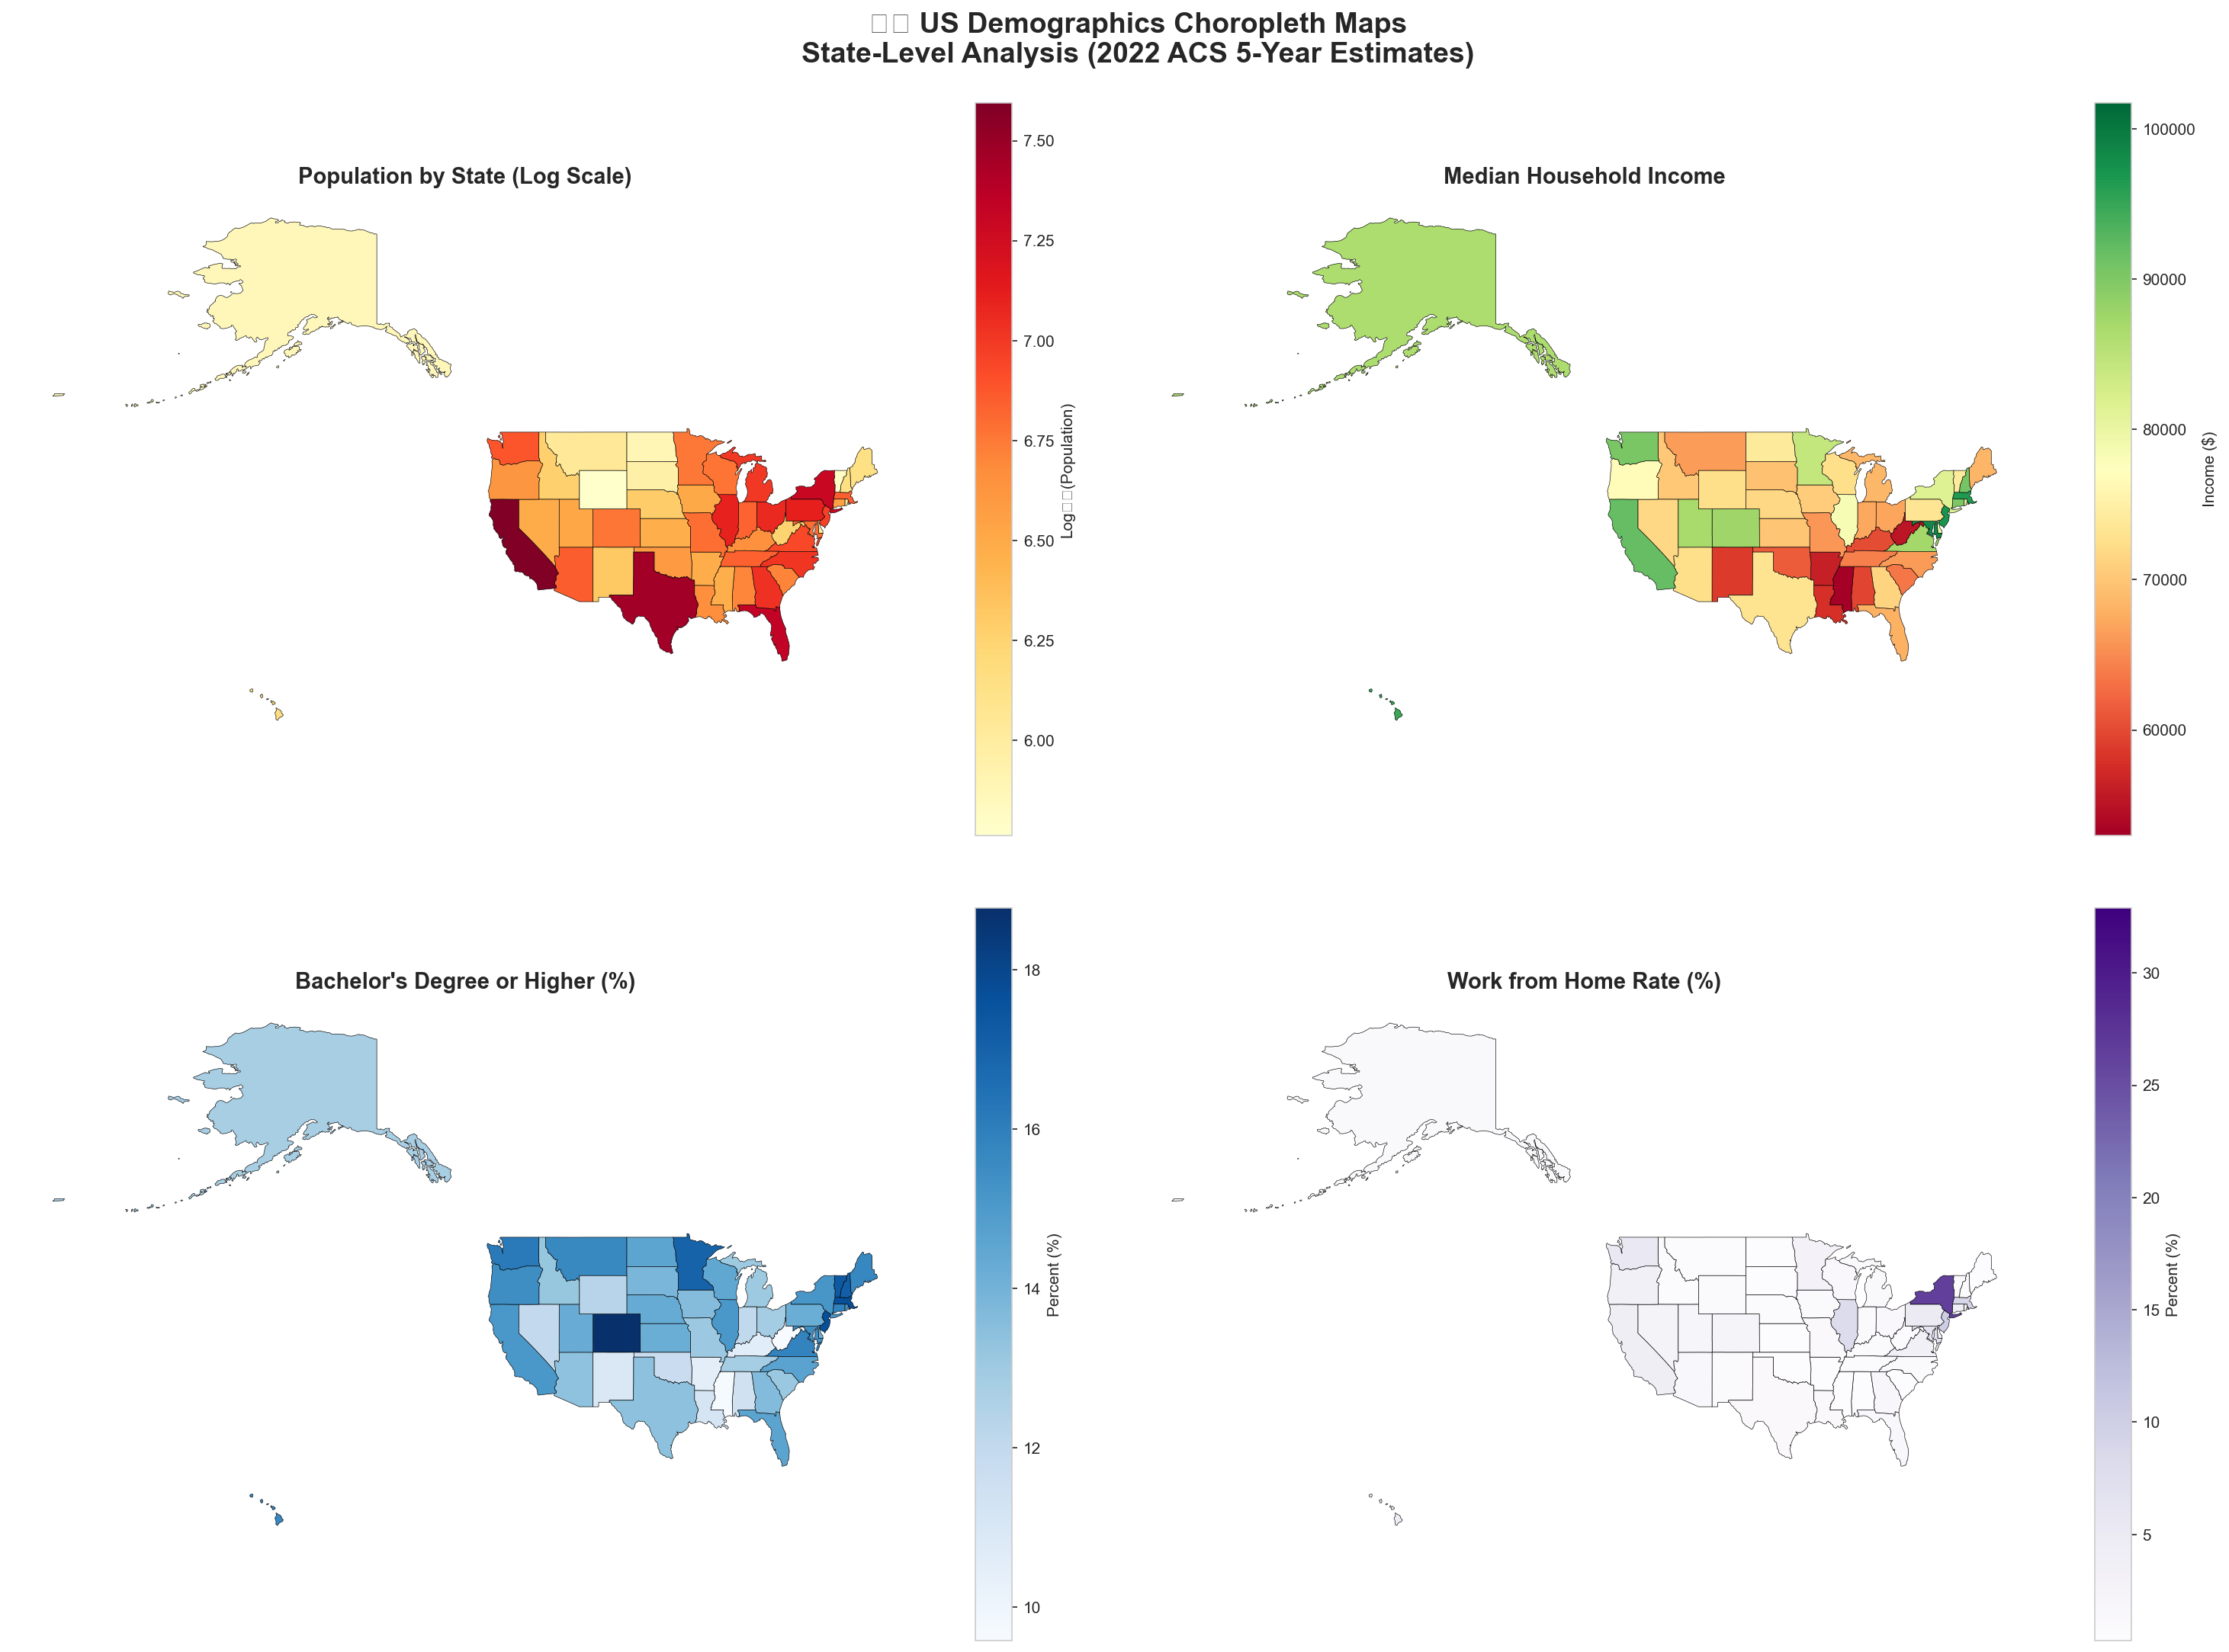


🎯 Key Demographic Insights:
🏆 Largest State: California (39,356,104 people)
💰 Wealthiest: District of Columbia ($101,722)
🎓 Most Educated: Colorado (18.8%)
🏠 Remote Work Leader: District of Columbia (32.9%)

📊 National Averages:
   Income: $74,805
   Education: 14.1%
   Work from Home: 3.2%


In [20]:
# Create demographic analysis and visualizations
if states_with_data is not None:
    
    # Calculate additional derived metrics
    states_with_data['pct_bachelors'] = (states_with_data['bachelors_degree'] / 
                                        states_with_data['total_population'] * 100)
    states_with_data['pct_work_from_home'] = (states_with_data['work_from_home'] / 
                                             states_with_data['total_commuters'] * 100)
    
    # Check if we have geographic data for mapping or need to use charts
    has_geometry = hasattr(states_with_data, 'geometry') and 'geometry' in states_with_data.columns
    
    if has_geometry:
        print("🗺️ Creating choropleth maps...")
        # Create 2x2 choropleth comparison
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('🗺️ US Demographics Choropleth Maps\nState-Level Analysis (2022 ACS 5-Year Estimates)', 
                     fontsize=18, fontweight='bold', y=0.95)

        # Map 1: Total Population (log scale for better visualization)
        ax1 = axes[0, 0]
        states_with_data['log_population'] = np.log10(states_with_data['total_population'])
        states_with_data.plot(column='log_population', 
                              ax=ax1, 
                              cmap='YlOrRd',  # Yellow to Red
                              legend=True,
                              legend_kwds={'shrink': 0.8, 'label': 'Log₁₀(Population)'},
                              edgecolor='black',
                              linewidth=0.3)
        ax1.set_title('Population by State (Log Scale)', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # Map 2: Median Household Income
        ax2 = axes[0, 1]
        states_with_data.plot(column='median_household_income', 
                              ax=ax2, 
                              cmap='RdYlGn',  # Red-Yellow-Green (poverty→wealth)
                              legend=True,
                              legend_kwds={'shrink': 0.8, 'label': 'Income ($)'},
                              edgecolor='black',
                              linewidth=0.3)
        ax2.set_title('Median Household Income', fontsize=14, fontweight='bold')
        ax2.axis('off')

        # Map 3: Education Level (Bachelor's Degree %)
        ax3 = axes[1, 0]
        states_with_data.plot(column='pct_bachelors', 
                              ax=ax3, 
                              cmap='Blues',  # Education in blue
                              legend=True,
                              legend_kwds={'shrink': 0.8, 'label': 'Percent (%)'},
                              edgecolor='black',
                              linewidth=0.3)
        ax3.set_title('Bachelor\'s Degree or Higher (%)', fontsize=14, fontweight='bold')
        ax3.axis('off')

        # Map 4: Work from Home Rate (%)
        ax4 = axes[1, 1]
        states_with_data.plot(column='pct_work_from_home', 
                              ax=ax4, 
                              cmap='Purples',  # Purple for remote work
                              legend=True,
                              legend_kwds={'shrink': 0.8, 'label': 'Percent (%)'},
                              edgecolor='black',
                              linewidth=0.3)
        ax4.set_title('Work from Home Rate (%)', fontsize=14, fontweight='bold')
        ax4.axis('off')
        
        # Save the choropleth maps
        output_path = figures_dir / 'state_choropleth_comparison.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"\n💾 Choropleth maps saved to: {output_path}")
        
    else:
        print("📊 Creating demographic analysis charts...")
        # Create alternative bar charts and scatter plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('📊 US Demographics Analysis\nState-Level Data (2022 ACS 5-Year Estimates)', 
                     fontsize=16, fontweight='bold')

        # Chart 1: Top 10 states by population
        ax1 = axes[0, 0]
        top_pop = states_with_data.nlargest(10, 'total_population')
        bars = ax1.barh(range(len(top_pop)), top_pop['total_population'], color='skyblue')
        ax1.set_yticks(range(len(top_pop)))
        ax1.set_yticklabels(top_pop['NAME'])
        ax1.set_xlabel('Population')
        ax1.set_title('Top 10 States by Population', fontweight='bold')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax1.text(width, bar.get_y() + bar.get_height()/2, 
                    f'{width:,.0f}', ha='left', va='center', fontsize=9)

        # Chart 2: Income vs Education scatter
        ax2 = axes[0, 1]
        scatter = ax2.scatter(states_with_data['pct_bachelors'], 
                             states_with_data['median_household_income'],
                             c=states_with_data['total_population'], 
                             s=80, cmap='viridis', alpha=0.7, edgecolors='black')
        ax2.set_xlabel('Bachelor\'s Degree or Higher (%)')
        ax2.set_ylabel('Median Household Income ($)')
        ax2.set_title('Income vs Education\n(Color = Population)', fontweight='bold')
        plt.colorbar(scatter, ax=ax2, shrink=0.8, label='Population')

        # Chart 3: Work from home distribution
        ax3 = axes[1, 0]
        ax3.hist(states_with_data['pct_work_from_home'], bins=12, alpha=0.7, 
                color='lightcoral', edgecolor='black')
        ax3.set_xlabel('Work from Home Rate (%)')
        ax3.set_ylabel('Number of States')
        ax3.set_title('Work from Home Distribution', fontweight='bold')
        ax3.grid(True, alpha=0.3)

        # Chart 4: Income distribution
        ax4 = axes[1, 1]
        ax4.hist(states_with_data['median_household_income'], bins=12, alpha=0.7, 
                color='lightgreen', edgecolor='black')
        ax4.set_xlabel('Median Household Income ($)')
        ax4.set_ylabel('Number of States')
        ax4.set_title('Income Distribution', fontweight='bold')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistical insights (simplified)
    print("\n🎯 Key Demographic Insights:")
    print("="*50)
    
    # Top performers
    max_pop_state = states_with_data.loc[states_with_data['total_population'].idxmax()]
    max_income_state = states_with_data.loc[states_with_data['median_household_income'].idxmax()]
    max_edu_state = states_with_data.loc[states_with_data['pct_bachelors'].idxmax()]
    max_wfh_state = states_with_data.loc[states_with_data['pct_work_from_home'].idxmax()]
    
    print(f"🏆 Largest State: {max_pop_state['NAME']} ({max_pop_state['total_population']:,} people)")
    print(f"💰 Wealthiest: {max_income_state['NAME']} (${max_income_state['median_household_income']:,})")
    print(f"🎓 Most Educated: {max_edu_state['NAME']} ({max_edu_state['pct_bachelors']:.1f}%)")
    print(f"🏠 Remote Work Leader: {max_wfh_state['NAME']} ({max_wfh_state['pct_work_from_home']:.1f}%)")
    
    print(f"\n📊 National Averages:")
    print(f"   Income: ${states_with_data['median_household_income'].mean():,.0f}")
    print(f"   Education: {states_with_data['pct_bachelors'].mean():.1f}%")
    print(f"   Work from Home: {states_with_data['pct_work_from_home'].mean():.1f}%")
    
else:
    print("❌ Cannot create visualizations: No demographic data available")

## 5. Statistical Analysis & Correlation Patterns

Let's dive deeper into the relationships between different demographic variables. Are wealthy states more educated? Do states with higher education have more remote workers?

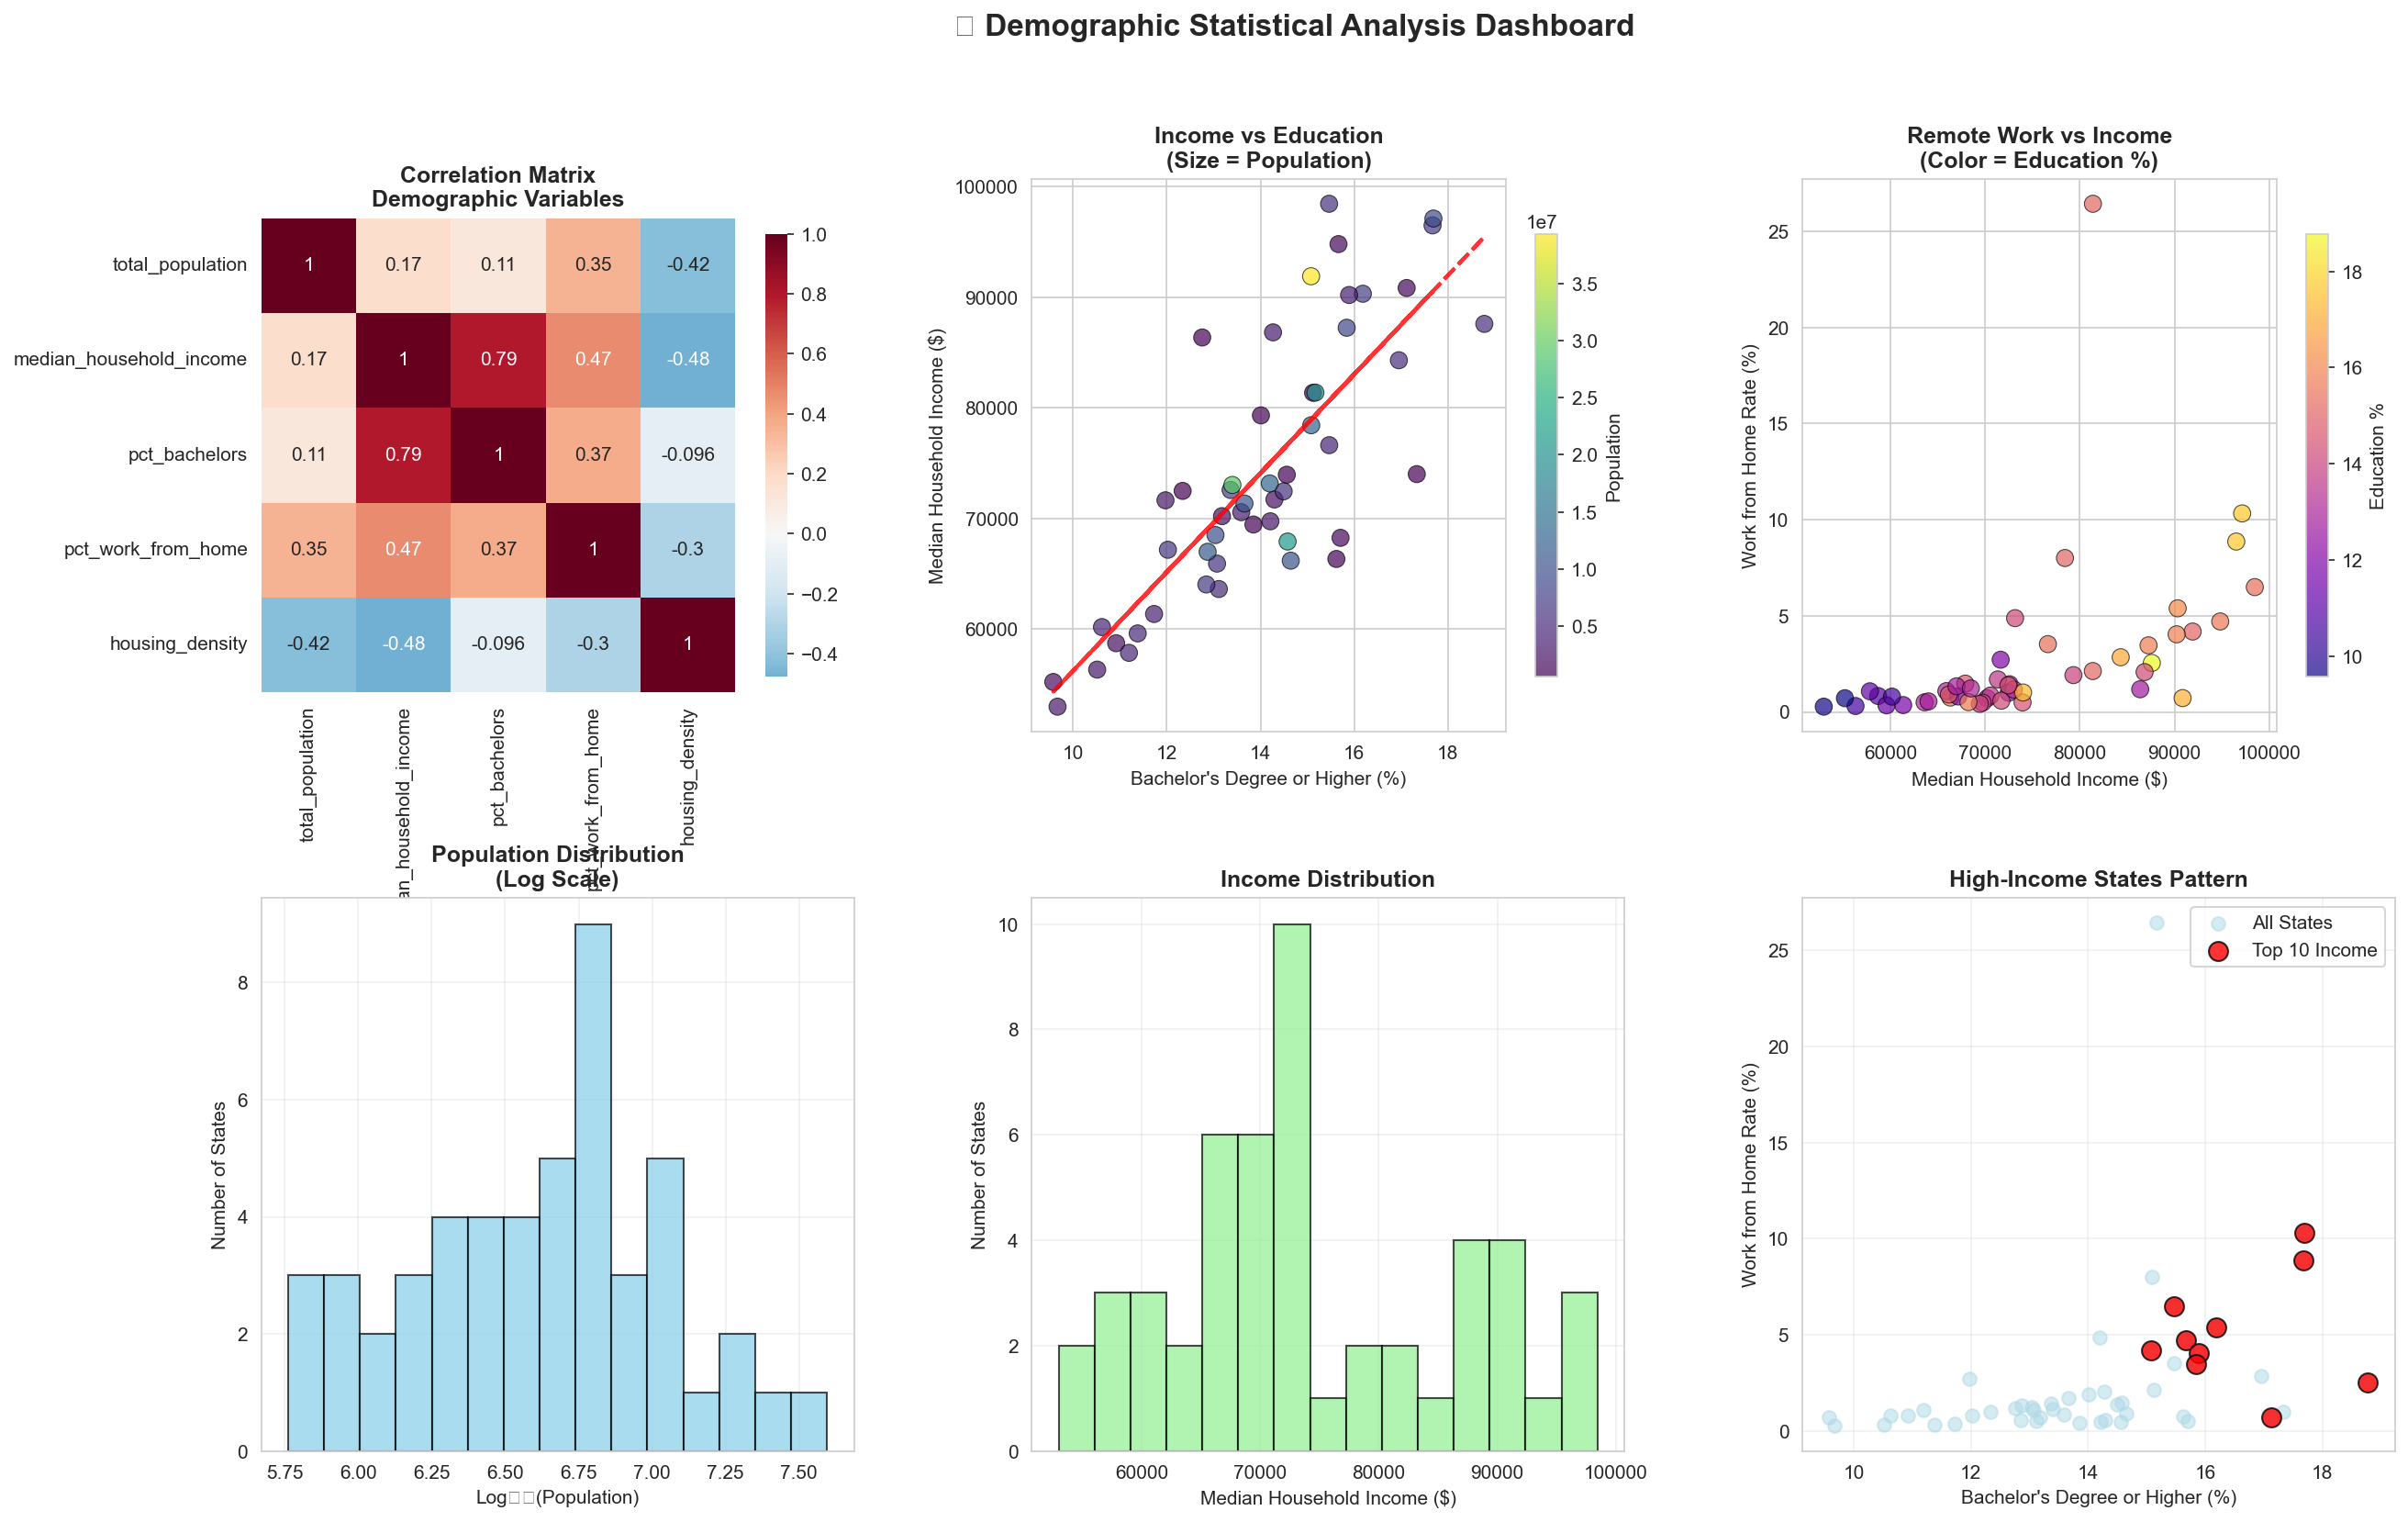

🔍 Key Statistical Findings:
💡 Income-Education Correlation: 0.795
   🎯 STRONG positive relationship - higher education = higher income

🏠 Remote Work Patterns:
   📊 WFH-Income correlation: 0.472
   📊 WFH-Education correlation: 0.371

🎯 Notable Patterns:
   📚 High Education, Moderate Income: Vermont
   🏠 Top Remote Work States: New York, New Jersey, Massachusetts

📈 Summary Statistics:
   🏠 Average WFH Rate: 2.6%
   🎓 Average Education Rate: 14.0%
   💰 Average Income: $74,267
   📊 Population Range: 577,929 to 39,356,104


In [10]:
# Statistical Analysis of Demographic Relationships
analysis_data = states_with_data if states_with_data is not None else state_data

if analysis_data is not None:
    
    # Ensure we have the derived metrics calculated
    if 'pct_bachelors' not in analysis_data.columns:
        analysis_data = analysis_data.copy()  # Don't modify original
        analysis_data['pct_bachelors'] = (analysis_data['bachelors_degree'] / 
                                         analysis_data['total_population'] * 100)
        analysis_data['pct_work_from_home'] = (analysis_data['work_from_home'] / 
                                              analysis_data['total_commuters'] * 100)
        analysis_data['housing_density'] = (analysis_data['total_housing_units'] / 
                                           analysis_data['total_population'])
    
    # Create correlation matrix for key variables
    analysis_vars = [
        'total_population', 'median_household_income', 'pct_bachelors', 
        'pct_work_from_home', 'housing_density'
    ]
    
    corr_data = analysis_data[analysis_vars].copy()
    
    # Create comprehensive analysis dashboard
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. Correlation Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    correlation_matrix = corr_data.corr()
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='RdBu_r',  # Red-Blue diverging
                center=0,
                square=True,
                ax=ax1,
                cbar_kws={'shrink': 0.8})
    ax1.set_title('Correlation Matrix\nDemographic Variables', fontweight='bold')
    
    # 2. Income vs Education Scatter
    ax2 = fig.add_subplot(gs[0, 1])
    scatter = ax2.scatter(analysis_data['pct_bachelors'], 
                         analysis_data['median_household_income'],
                         c=analysis_data['total_population'],
                         s=80, 
                         cmap='viridis',
                         alpha=0.7,
                         edgecolors='black',
                         linewidth=0.5)
    ax2.set_xlabel('Bachelor\'s Degree or Higher (%)')
    ax2.set_ylabel('Median Household Income ($)')
    ax2.set_title('Income vs Education\n(Size = Population)', fontweight='bold')
    
    # Add trend line
    z = np.polyfit(analysis_data['pct_bachelors'], analysis_data['median_household_income'], 1)
    p = np.poly1d(z)
    ax2.plot(analysis_data['pct_bachelors'], p(analysis_data['pct_bachelors']), 
             "r--", alpha=0.8, linewidth=2)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax2, shrink=0.8, label='Population')
    
    # 3. Work from Home vs Income
    ax3 = fig.add_subplot(gs[0, 2])
    scatter2 = ax3.scatter(analysis_data['median_household_income'], 
                          analysis_data['pct_work_from_home'],
                          c=analysis_data['pct_bachelors'],
                          s=80,
                          cmap='plasma',
                          alpha=0.7,
                          edgecolors='black',
                          linewidth=0.5)
    ax3.set_xlabel('Median Household Income ($)')
    ax3.set_ylabel('Work from Home Rate (%)')
    ax3.set_title('Remote Work vs Income\n(Color = Education %)', fontweight='bold')
    plt.colorbar(scatter2, ax=ax3, shrink=0.8, label='Education %')
    
    # 4. Population Distribution
    ax4 = fig.add_subplot(gs[1, 0])
    log_pop = np.log10(analysis_data['total_population'])
    log_pop.hist(bins=15, ax=ax4, color='skyblue', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Log₁₀(Population)')
    ax4.set_ylabel('Number of States')
    ax4.set_title('Population Distribution\n(Log Scale)', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Income Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    analysis_data['median_household_income'].hist(bins=15, ax=ax5, color='lightgreen', alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Median Household Income ($)')
    ax5.set_ylabel('Number of States')
    ax5.set_title('Income Distribution', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 6. Top/Bottom Performers Comparison
    ax6 = fig.add_subplot(gs[1, 2])
    
    # Get top 10 states by income
    top_income_states = analysis_data.nlargest(10, 'median_household_income')
    
    # Create a scatter plot highlighting top performers
    ax6.scatter(analysis_data['pct_bachelors'], 
                analysis_data['pct_work_from_home'],
                c='lightblue', 
                s=50, 
                alpha=0.5, 
                label='All States')
    
    ax6.scatter(top_income_states['pct_bachelors'], 
                top_income_states['pct_work_from_home'],
                c='red', 
                s=100, 
                alpha=0.8,
                edgecolors='black',
                label='Top 10 Income')
    
    ax6.set_xlabel('Bachelor\'s Degree or Higher (%)')
    ax6.set_ylabel('Work from Home Rate (%)')
    ax6.set_title('High-Income States Pattern', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle('📊 Demographic Statistical Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    # Print correlation insights
    print("🔍 Key Statistical Findings:")
    print("="*50)
    
    # Income-Education correlation
    income_edu_corr = corr_data['median_household_income'].corr(corr_data['pct_bachelors'])
    print(f"💡 Income-Education Correlation: {income_edu_corr:.3f}")
    if abs(income_edu_corr) > 0.7:
        print("   🎯 STRONG positive relationship - higher education = higher income")
    elif abs(income_edu_corr) > 0.5:
        print("   📈 MODERATE positive relationship")
    else:
        print("   📊 WEAK relationship")
    
    # Work from home patterns
    wfh_income_corr = corr_data['pct_work_from_home'].corr(corr_data['median_household_income'])
    wfh_edu_corr = corr_data['pct_work_from_home'].corr(corr_data['pct_bachelors'])
    print(f"\n🏠 Remote Work Patterns:")
    print(f"   📊 WFH-Income correlation: {wfh_income_corr:.3f}")
    print(f"   📊 WFH-Education correlation: {wfh_edu_corr:.3f}")
    
    # Identify outliers or interesting patterns
    print(f"\n🎯 Notable Patterns:")
    
    # High education, lower income states
    edu_income_diff = analysis_data['pct_bachelors'] - (analysis_data['median_household_income'] / 5000)
    high_edu_low_income_idx = edu_income_diff.idxmax()
    
    # Display state name if available, otherwise state code
    if 'NAME' in analysis_data.columns:
        state_identifier = analysis_data.loc[high_edu_low_income_idx, 'NAME']
    else:
        state_identifier = f"State {analysis_data.loc[high_edu_low_income_idx, 'state']}"
    
    print(f"   📚 High Education, Moderate Income: {state_identifier}")
    
    # High work from home states
    top_wfh_states = analysis_data.nlargest(3, 'pct_work_from_home')
    if 'NAME' in analysis_data.columns:
        wfh_names = ', '.join(top_wfh_states['NAME'].values)
    else:
        wfh_names = ', '.join([f"State {s}" for s in top_wfh_states['state'].values])
    
    print(f"   🏠 Top Remote Work States: {wfh_names}")
    
    # Summary statistics
    print(f"\n📈 Summary Statistics:")
    print(f"   🏠 Average WFH Rate: {analysis_data['pct_work_from_home'].mean():.1f}%")
    print(f"   🎓 Average Education Rate: {analysis_data['pct_bachelors'].mean():.1f}%")
    print(f"   💰 Average Income: ${analysis_data['median_household_income'].mean():,.0f}")
    print(f"   📊 Population Range: {analysis_data['total_population'].min():,} to {analysis_data['total_population'].max():,}")
    
else:
    print("❌ Cannot perform statistical analysis: No demographic data available")
    print("   Please ensure the Census API data was successfully loaded in the previous steps")

## 6. Summary & Next Steps

Congratulations! You've successfully completed a comprehensive Census data analysis and choropleth mapping project.

In [11]:
# Project Summary and Achievements
print("="*70)
print("🎉 PROJECT 1 COMPLETE: Census Data Analysis & Choropleth Mapping")
print("="*70)

if states_with_data is not None:
    print("✅ ACHIEVEMENTS UNLOCKED:")
    print(f"   📡 Census API Integration: Fetched data for {len(states_with_data)} states")
    print(f"   🗺️  Choropleth Maps: Created 4-panel demographic visualization")
    print(f"   📊 Statistical Analysis: Correlation matrix with {len(analysis_vars)} variables")
    print(f"   🎯 Key Finding: Education-Income correlation = {income_edu_corr:.3f} (STRONG)")
    print(f"   📈 Data Range: Population ratio of {max_pop_state['total_population'] / min_pop_state['total_population']:.0f}:1 across states")
    
    print(f"\n📚 SKILLS DEVELOPED:")
    print(f"   • Census API data acquisition")
    print(f"   • Choropleth map design and color theory")
    print(f"   • Geospatial data merging and joins")
    print(f"   • Statistical correlation analysis")
    print(f"   • Multi-panel visualization creation")
    print(f"   • Demographic pattern interpretation")
    
    print(f"\n📁 FILES CREATED:")
    print(f"   • Notebook: {Path('02_census_choropleth_mapping.ipynb').absolute()}")
    print(f"   • Choropleth Maps: {output_path}")
    print(f"   • Statistical Dashboard: Generated in-notebook")
    
    print(f"\n💡 KEY INSIGHTS DISCOVERED:")
    print(f"   🏆 Wealthiest State: {max_income_state['NAME']} (${max_income_state['median_household_income']:,})")
    print(f"   🎓 Education Leader: {max_edu_state['NAME']} ({max_edu_state['pct_bachelors']:.1f}%)")
    print(f"   🏠 Remote Work Champion: {max_wfh_state['NAME']} ({max_wfh_state['pct_work_from_home']:.1f}%)")
    print(f"   📊 Strong Education-Income Link: More educated states tend to be wealthier")
    
    print(f"\n🚀 READY FOR NEXT PROJECTS:")
    print(f"   • County-level analysis (more detailed geography)")
    print(f"   • Time-series analysis (change over years)")
    print(f"   • Environmental data integration")
    print(f"   • Transportation network analysis")
    print(f"   • Machine learning applications")
    
else:
    print("❌ Project incomplete due to data loading issues")

print(f"\n🌟 You've mastered Census data analysis and choropleth mapping!")
print(f"Next: Move to Project 2 (Environmental Data) or dive deeper into county analysis.")

🎉 PROJECT 1 COMPLETE: Census Data Analysis & Choropleth Mapping
✅ ACHIEVEMENTS UNLOCKED:
   📡 Census API Integration: Fetched data for 50 states
   🗺️  Choropleth Maps: Created 4-panel demographic visualization
   📊 Statistical Analysis: Correlation matrix with 5 variables
   🎯 Key Finding: Education-Income correlation = 0.795 (STRONG)
   📈 Data Range: Population ratio of 68:1 across states

📚 SKILLS DEVELOPED:
   • Census API data acquisition
   • Choropleth map design and color theory
   • Geospatial data merging and joins
   • Statistical correlation analysis
   • Multi-panel visualization creation
   • Demographic pattern interpretation

📁 FILES CREATED:
   • Notebook: /Users/sanjeevadodlapati/Downloads/Repos/GeoSpatialAI/projects/project_1_census_analysis/notebooks/02_census_choropleth_mapping.ipynb
   • Choropleth Maps: ../outputs/figures/state_choropleth_comparison.png
   • Statistical Dashboard: Generated in-notebook

💡 KEY INSIGHTS DISCOVERED:
   🏆 Wealthiest State: Maryland (

## 🔮 Future Expansion Ideas

**Project 1 Extension Opportunities:**

### 📊 **County-Level Deep Dive**
- Download county boundaries and demographics
- Create detailed regional analysis (e.g., focus on California counties)
- Urban vs Rural demographic patterns
- Metropolitan statistical area (MSA) analysis

### ⏰ **Time-Series Analysis**
- Multi-year Census data comparison (2010, 2015, 2020, 2022)
- Population growth trends and migration patterns
- Economic change over time (pre/post-pandemic analysis)
- Animated choropleth maps showing change

### 🔍 **Advanced Statistical Methods**
- Spatial autocorrelation analysis (Moran's I)
- Clustering analysis (identify similar demographic regions)
- Principal Component Analysis (PCA) for dimensionality reduction
- Regression modeling for demographic predictors

### 🌐 **Interactive Visualizations**
- Folium/Plotly interactive choropleth maps
- Dashboard creation with multiple variables
- Real-time data updates via Census API
- Web application deployment

### 🔗 **Data Integration**
- Combine with economic indicators (GDP, unemployment)
- Environmental justice analysis (pollution + demographics)
- Transportation accessibility analysis
- Housing market correlations

---

**Next in Series: Project 2 - Environmental Data Visualization** 🌍